In [1]:
#
# This program calculates the great circle that minimizes the total distance between a set of points and it.
# It uses a numerical approximation method: 
# - an initial selection of randomly generated great-circles,
# - a gradient search afterwards.
# Formulas from: https://www.movable-type.co.uk/scripts/latlong.html
# Additionally it creates some charts:
# - several plots showing the convergence of the solutions,
# - a picture of the total distance for "all" great-circles.
# Units: 
# - distance: km, 
# - angle: degrees for input, radians for internal calculations.
# The coordinates are entered as (lon, lat), NOT (lat, lon).


In [2]:
# Version log.
# 
# R0 (20200330)
# First trials.
# Seems to work well.


In [99]:
# Files and directories.
# Directories.
RootDir = 'D:/0 DOWN/00 PY RG/GIS/GEODIST/IO DATA/'

# I/O files:
FileNameOut1 = RootDir + 'GEODIST_out R0.csv'


In [ ]:
# Input data (from www.latlon.net).
# All points have this structure: [description, LON, LAT].
CRD = [ 
    ['NYC', radians(-73.935242), radians( 40.730610)],
    ['TEH', radians( 51.404343), radians( 35.715298)],
    ['BEI', radians(116.383331), radians( 39.916668)],
    ['MAD', radians( -3.703790), radians( 40.416775)]
]


In [4]:
# Import modules.
from math import radians, degrees, cos, sin, asin, atan2, sqrt, pi
from random import uniform
import matplotlib.pyplot as plt

# Nice printing.
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"


In [62]:
# Functions.
def f_bearing(P1, P2):
    """
    Calculates the bearing between two points.
    """
    LON1, LAT1 = P1[1], P1[2]
    LON2, LAT2 = P2[1], P2[2]
    Y = sin(LON2-LON1) * cos(LAT2)
    X = cos(LAT1) * sin(LAT2) - sin(LAT1) * cos(LAT2) * cos(LON2 - LON1)
    B = atan2(Y, X)
    return B


def f_dist(P1, P2, R = 6371.):
    '''
    Calculates the great-circle distance btw two points.
    '''
    LON1, LAT1 = P1[1], P1[2]
    LON2, LAT2 = P2[1], P2[2]
    DLON = LON2 - LON1
    DLAT = LAT2 - LAT1
    A = (sin(DLAT/2))**2 + cos(LAT1) * cos(LAT2) * (sin(DLON/2))**2
    C = 2 * atan2(sqrt(A), sqrt(1.- A))
    D = R * C
    if (D > pi * R):
        print ('Warning: f_dist(P1, P2) = {0:8.1f} > PI*R for P1 = {1} and P2 = {2}'.format(D, P1, P2))
    return D
    
    
def f_cross(P1, P2, P3, R = 6371.):
    '''
    Calculates the cross-track distance: the distance between P3 and the geodesic btw P1 and P2.
    Sign is eliminated.
    '''
    B12 = f_bearing(P1, P2)
    B13 = f_bearing(P1, P3)
    d13 = f_dist(P1, P3) / R
    D   = asin(sin(d13) * sin(B13 - B12)) * R
    if (abs(D) > pi * R / 2):
        print ('Warning: f_cross(P1, P2, P3)= {0:8.1f} > PI*R/2 for P1= {1}, P2= {2}  and P3= {3}'.format(D, P1, P2, P3))
    return abs(D)


def f_sum(PA, PB, CRD):
    '''
    Calculates the sum of the cross distances btw the geodesic (great-circle) btw PA and PB and all the points in CRD.
    '''
    D = 0.
    for P in CRD:
        D += f_cross(PA, PB, P)
    return D

def f_int(P1, P2, f, R = 6371.):
    ''' 
    Calculates an intermediate point in the great circle PA-PB whose distance from PA is a fraction (f) of dist(PA-PB).
    '''
    LON1, LAT1 = P1[1], P1[2]
    LON2, LAT2 = P2[1], P2[2]
    d12  = f_dist(P1, P2) / R
    A    = sin(d12 * (1.-f)) / sin(d12)
    B    = sin(d12 * f     ) / sin(d12)
    X    = A * cos(LAT1) * cos(LON1) + B * cos(LAT2) * cos(LON2)
    Y    = A * cos(LAT1) * sin(LON1) + B * cos(LAT2) * sin(LON2)
    Z    = A * sin(LAT1)             + B * sin(LAT2)
    LATi = atan2(Z, sqrt(X**2 + Y**2))
    LONi = atan2(Y, X)
    return [LONi, LATi]


In [71]:
# Random iterations - effect of the number of iterations.
Niter   = 50
cnt_ref = 2000
RES     = []

for i in range(0, Niter, 1):
    aux = []
    DS0     = 1E10
    cnt_max = (i+1) * cnt_ref / (Niter + 1) # Increase the number of iterations within the loop.
    cnt     = 0
    while cnt < cnt_max: 
        PA  = ['PA', radians(uniform(0., 360.)), radians(10.)]
        PB  = ['PB', radians(uniform(0., 360.)), radians(10.)]        
        DS  = f_sum(PA, PB, CRD)
        if DS < DS0:
            PA0 = PA
            PB0 = PB
            DS0 = DS
            aux.append([PA[1], PB[1], cnt, DS, cnt_max])
        cnt += 1
        #if cnt % 100 == 0:
        #    print (cnt)

    # Take a look:
    print_out = False
    if print_out:
        print('Number of iterations: {0:8.0f}'.format(cnt_max))
        print ('DS at final point: {0:8.1f}'.format(DS0))
        for x in CRD:
            print ('DS to {0}: {1:8.1f}'.format(x[0], f_cross(PA0, PB0, x)))
        print ('{0}: {1:5.3f}, {2:5.3f}'.format(PA0[0], PA0[1], PA0[2]))
        print ('{0}: {1:5.3f}, {2:5.3f}'.format(PB0[0], PB0[1], PB0[2]))
        print (i)
    RES.append(aux)


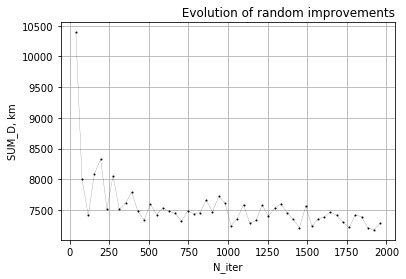

In [72]:
# Visualize the evolution of the results:
fig, ax = plt.subplots()
# Organize the results.
RESd = [x[-1][3] for x in RES]
RESe = [x[ 0][4] for x in RES]
    
ax.plot(RESe, RESd, c = 'k', linestyle = '--', linewidth = 0.2, marker = '.', markersize = 2)

ax.set_title(' Evolution of random improvements', loc = 'right')
ax.set_xlabel('N_iter')
ax.set_ylabel('SUM_D, km')
#ax.set_xlim(0, 2*pi)
#ax.set_ylim(0, 2*pi)
ax.grid(True)
plt.show()


In [73]:
# Random iterations.
Niter   = 10
cnt_max = 10000
RES     = []

for i in range(0, Niter, 1):
    aux = []
    DS0     = 1E10
    cnt     = 0
    while cnt < cnt_max: 
        # Define PA and PB randomly along the LAT=10º circle.
        # The great circles have 2 degrees of freedom, and it is easier to fix LAT.
        # The distances are correctly calculated even if the points are in the southern hemisphere.
        # LAT != 0 to avoid having just one great-circle.
        PA  = ['PA', uniform(0,    pi), radians(10.)]
        PB  = ['PB', uniform(pi, 2*pi), radians(10.)]        
        DS  = f_sum(PA, PB, CRD)
        if DS < DS0:
            PA0 = PA
            PB0 = PB
            DS0 = DS
            aux.append([PA[1], PB[1], cnt, DS])
        cnt += 1

    # Take a look:
    print_out = False
    if print_out:
        print ('DS at final iteration: {0:8.1f}'.format(DS0))
        for x in CRD:
            print ('DS to {0}: {1:8.1f}'.format(x[0], f_cross(PA0, PB0, x)))
        print ('{0}: {1:5.3f}, {2:5.3f}'.format(PA0[0], PA0[1], PA0[2]))
        print ('{0}: {1:5.3f}, {2:5.3f}'.format(PB0[0], PB0[1], PB0[2]))
        print (i)
    RES.append(aux)


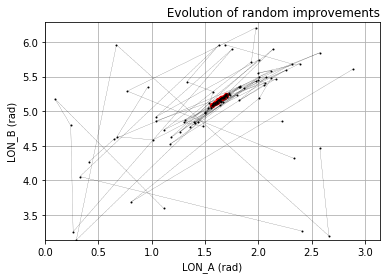

In [74]:
# Visualize the evolution of the results:
fig, ax = plt.subplots()
for i in range(0, len(RES), 1):
    # Organize the results.
    RESa = [x[0] for x in RES[i]]
    RESb = [x[1] for x in RES[i]]
    
    ax.plot(RESa, RESb, c = 'k', linestyle = '--', linewidth = 0.2, marker = '.', markersize = 2)
    ax.scatter(RESa[-1], RESb[-1], c = 'r', s = 20)

ax.set_title(' Evolution of random improvements', loc = 'right')
ax.set_xlabel('LON_A (rad)')
ax.set_ylabel('LON_B (rad)')
ax.set_xlim(0, pi)
ax.set_ylim(pi, 2*pi)
ax.grid(True)
plt.show()


In [75]:
# Further iteration through the gradient.
EPS = 0.001
cnt = 0
cnt_max = 10000

while cnt < cnt_max: 
    PA1 = ['PA1', PA0[1] * (1 + EPS), PA0[2]]
    PB1 = ['PB1', PB0[1] * (1 + EPS), PB0[2]]
    DSA  = f_sum(PA1, PB0, CRD)
    DSB  = f_sum(PA0, PB1, CRD)
    DSAg = (DSA - DS0) / (PA0[1] * EPS)
    DSBg = (DSB - DS0) / (PB0[1] * EPS)
    DSgn = sqrt(DSAg**2 + DSBg**2)
    DSgu = ['DSg', DSAg / DSgn, DSBg / DSgn]
    PA2  = ['PA2', PA0[1] * ( 1 - DSgu[1] * EPS), PA0[2]]
    PB2  = ['PB2', PB0[1] * ( 1 - DSgu[2] * EPS), PB0[2]]
    DS2  = f_sum(PA2, PB2, CRD)
    if DS2 > DS0: # stop iterations
        break
    else:
        DS0 = DS2
        PA0 = PA2
        PB0 = PB2
    cnt += 1

# Take a look:
print_out = True
if print_out:
    print ('cnt = {0:d}; DS at final point = {1:8.1f}'.format(cnt, DS0))
    for x in CRD:
        print ('DS to {0}: {1:8.1f}'.format(x[0], f_cross(PA0, PB0, x)))
    print ('{0}: {1:5.3f}, {2:5.3f}'.format(PA0[0], PA0[1], PA0[2]))
    print ('{0}: {1:5.3f}, {2:5.3f}'.format(PB0[0], PB0[1], PB0[2]))
    

cnt = 2; DS at final point =   7205.2
DS to NYC:   2788.2
DS to TEH:      6.7
DS to BEI:   4174.9
DS to MAD:    235.4
PA2: 1.568, 0.175
PB2: 5.084, 0.175


In [77]:
# Intermediate points along the great circle.
GRC = []
GRC.append(PA0[1:])
Np  = 100
for i in range(1, Np, 1):
    GRC.append(f_int(PA0, PB0, i / Np))
GRC.append(PB0[1:])


In [78]:
# Convert to degrees.
GRCd = [[degrees(x[0]), degrees(x[1])] for x in GRC]

# Take a look:
print_out = False
if print_out:
    print(GRCd[0:10])
    print(GRCd[-10:])

In [100]:
# Save the results.
with open(FileNameOut1, 'w') as file:
    for item in GRCd:
        file.write("{0}, {1}\n".format(item[0], item[1]))
file.close()


In [ ]:
#
# CREATE A CHART FOR THE DISTANCES FROM "ALL" GREAT-CIRCLES.
#

In [86]:
# Imports modules.
import numpy as np
from PIL import Image


In [87]:
# Color functions.
# Sources: 
# Functions: https://stackoverflow.com/questions/2353211/hsl-to-rgb-color-conversion
# Comments: https://stackoverflow.com/questions/17525215/calculate-color-values-from-green-to-red/17527156#17527156

def f_hue_aux(P, Q, T):
    '''
    Auxiliary function.
    '''
    t = T
    if (t < 0):
        t += 1
    if (t > 1):
        t -= 1
    if (t < 1/6):
        return P + (Q - P) * 6 * t
    if (t < 1/2):
        return Q
    if (t < 2/3):
        return P + (Q - P) * (2/3 - t) * 6
    else:
        return P

def f_hsl2rgb(H, S, L):
    '''
    Converts from hsl to rgb.
    '''  
    if S == 0:
        G = round(L*255) # Achromatic, use its lightness for a grey-scale color
        return (G, G, G)
    if L < 0.5:
        Q = L * (1 + S)
    else:
        Q = L + S - L * S
    P = 2 * L- Q
        
    R = int(round(255 * f_hue_aux(P, Q, H + 1/3)))
    G = int(round(255 * f_hue_aux(P, Q, H      )))
    B = int(round(255 * f_hue_aux(P, Q, H - 1/3)))

    return (R, G, B)

def f_n2rgb(i, H0 = 0, H1 = 360):
    '''
    Maps values in the range [0, 1] to a continuous HSL color space, then converts to RGB.
    '''
    # Map i*[H0, H1] into i*[0, 360]:
    H = ((i * (H1 - H0)) + H0) / 360
    # Convert hsl to rgb (saturation 100%, lightness 50%)
    RGB = f_hsl2rgb(H, 1, .5)
    return RGB


In [90]:
# Picture of the results.
Npix = 360
RESm = np.zeros((Npix, Npix), dtype = int)
i = 0
for A in np.linspace(0., pi, Npix, endpoint = False):
    j = 0
    for B in np.linspace(pi, 2*pi, Npix, endpoint = False):
        PA  = ['PA', A, radians(10.)]
        PB  = ['PB', B, radians(10.)]        
        DS  = f_sum(PA, PB, CRD)
        RESm[i, j] = int(DS)
        j += 1
    i += 1

# Take a look:
print (RESm.max(), RESm.min())


20961 7112


In [91]:
# Create the image:

# Auxiliary variables:
fscale = 5 # so that the image is 5*(Npix, Npix)
Cmin   = RESm.min()
Crange = RESm.max() - Cmin # Range of values to be mapped into the RGB space.
 
# Create a new black image:
imgA   = Image.new( 'RGB', (Npix,Npix), "black") 

# Create the pixel map:
imgAmap = imgA.load() 

# Edit the pixels:
for i in range(Npix): 
    for j in range(Npix):
        imgAmap[j, i] = f_n2rgb((RESm[i,j] - Cmin) / Crange)

# Show the result:
imgA.show()


In [101]:
# Resize and save.
imgAr = imgA.resize((Npix*fscale, Npix*fscale))

FileNameOut2 = RootDir + 'GEODIST_out R0.png'
imgAr.save(FileNameOut2)
